# Fish Classification

# Import Library

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import cv2
from keras import preprocessing
import numpy as np
import tensorflow as tf

# Mount Drive

In [ ]:
drive.mount('/content/mydrive', True)

Mounted at /content/mydrive


# Load Model

In [ ]:
from distutils.dir_util import copy_tree
copy_tree('/content/mydrive/My Drive/datasets/fish_classification_model', '/content/fish_classification_model/')

In [ ]:
fish_classification_model = tf.keras.models.load_model('/content/fish_classification_model/fish_classification.h5')

In [ ]:
fish_classification_model = tf.keras.models.load_model('/content/mydrive/My Drive/datasets/fish_classification_model/fish_classification.h5')

# Image Processing Function

In [ ]:
import urllib

def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  # plt.imshow(image)
  return image

def resizeAndPad(img, size, padColor=0):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img


# Variables

In [ ]:
class_name = ['BANDENG', 'GURAME', 'KERAPU', 'NILA']

width = 200
height = 200

# Predict Fish Class Function

In [ ]:
def predict_fish_classification(image_link):
  image_url = str(image_link)
  image_url = image_url+'?alt=media'
  image = url_to_image(image_url)
  # image = 'IMG_20210126_135506.jpg'
  # image = cv2.imread(image)
  image = resizeAndPad(image, (width, height))
  image = image[...,::-1]
  type_predict = np.expand_dims(image, axis=0)
  pred = fish_classification_model.predict(type_predict)
  jenis_ikan = class_name[np.argmax(pred)]

  jenis_ikan_confidence = int(round(pred[0][np.argmax(pred)], 2) * 100)

  jenis_dan_confidence = jenis_ikan + ' ' + str(jenis_ikan_confidence) + '%'

  print(pred)
  print(jenis_ikan)

  # plt.imshow(image)
  # plt.show()
  # return jenis_ikan
  return jenis_dan_confidence

# Detect Fish Eye

# Install Dependencies

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
!pip install torch==1.8 torchvision==0.9.0
# !pip install 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.0 False
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


# Import Detectron Library

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import pandas as pd
import os, json, random, itertools, uuid
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode

# Copy Detectron2 Model From Drive

In [ ]:
from distutils.dir_util import copy_tree
copy_tree('/content/mydrive/My Drive/detectron2/', '/content/fish_eye/')
copy_tree('/content/mydrive/My Drive/detectron2_output/', '/content/my_trained')
# copy_tree('/content/drive/My Drive/datasets/fish_dataset/eye_for_detectron_inference/', '/content/resized_eye/')

['/content/my_trained/model_final.pth',
 '/content/my_trained/last_checkpoint',
 '/content/my_trained/metrics.json',
 '/content/my_trained/events.out.tfevents.1621100399.c6bfda2e000e.63.0']

# Dataset Catalog

In [ ]:
# write a function that loads the dataset into detectron2's standard format
def get_fish_eye_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['filename'].map(lambda x: img_dir+x)

    classes = ['bandeng_eye', 'gurame_eye', 'kerapu_eye', 'nila_eye']

    df['class_int'] = df['class'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['bandeng_eye', 'gurame_eye', 'kerapu_eye', 'nila_eye']

for d in ["train", "test"]:
  DatasetCatalog.register('fish/' + d, lambda d=d: get_fish_eye_dicts('fish_eye/' + d + '_eye_labels.csv', 'fish_eye/' + d+'/'))
  MetadataCatalog.get('fish/' + d).set(thing_classes=classes)
fish_eye_metadata = MetadataCatalog.get('fish/train')

# Load Detectron2 Model

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'))
cfg.DATASETS.TRAIN = ('fish/train',)
cfg.DATASETS.TEST = ('fish/test',)
cfg.MODEL.WEIGHTS = '/content/my_trained/model_final.pth'
cfg.MODEL.DEVICE = 'cpu'
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
predictor = DefaultPredictor(cfg)

# Variables

In [ ]:
detect_eye_picture_width = 1000
detect_eye_picture_height = 1000

crop_eye_width = 200
crop_eye_height = 200

# Detectron2 Model Inference

In [ ]:
def detect_fish_eye_position(image_link):
  image_url = str(image_link)
  image_url = image_url+'?alt=media'
  image = url_to_image(image_url)
  img = resizeAndPad(image, (detect_eye_picture_width, detect_eye_picture_height), 0)
  outputs = predictor(img)
  v = Visualizer(img[:, :, ::-1], metadata=fish_eye_metadata, scale=1)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  # plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
  # plt.show()
  boxes = {}
  for coordinates in outputs["instances"].to("cpu").pred_boxes:
    coordinates_array = []
    for k in coordinates:
      coordinates_array.append(int(k))
    boxes[uuid.uuid4().hex[:].upper()] = coordinates_array
  for k,v in boxes.items():
    crop_img = img[v[1]:v[3], v[0]:v[2], :]
    resized_img = resizeAndPad(crop_img, (crop_eye_width, crop_eye_width), 0)
    # plt.imshow(resized_img)
    # plt.show()
  
  # plt.imshow(resized_img)
  # plt.show()

  if (len(boxes) > 0):
    return resized_img
  
  return 'No Eye Detected'


  # return resized_img

# Predict Freshness From Fish Eye

# Variables

In [ ]:
freshness_class_name = ['SEGAR', 'CUKUP_SEGAR', 'TIDAK_SEGAR']

# Load Model For Eye Freshness

In [ ]:
# !cp '/content/mydrive/My Drive/eye_model_h5.zip' '/content/eye_model_h5.zip'
!unzip '/content/mydrive/My Drive/eye_model_h5.zip' -d '/content/model_eye'

Archive:  /content/mydrive/My Drive/eye_model_h5.zip
   creating: /content/model_eye/content/modelh5/
  inflating: /content/model_eye/content/modelh5/kerapu_eye_model.h5  
  inflating: /content/model_eye/content/modelh5/bandeng_eye_model.h5  
  inflating: /content/model_eye/content/modelh5/gurame_eye_model.h5  
  inflating: /content/model_eye/content/modelh5/nila_eye_model.h5  


In [ ]:
bandeng_eye_model_load = tf.keras.models.load_model('/content/model_eye/content/modelh5/bandeng_eye_model.h5')
gurame_eye_model_load = tf.keras.models.load_model('/content/model_eye/content/modelh5/gurame_eye_model.h5')
kerapu_eye_model_load = tf.keras.models.load_model('/content/model_eye/content/modelh5/kerapu_eye_model.h5')
nila_eye_model_load = tf.keras.models.load_model('/content/model_eye/content/modelh5/nila_eye_model.h5')

# Eye Model Inference

In [ ]:
def predict_eye_freshness(cropped_eye, jenis_ikan):
  image = cropped_eye
  image = image[...,::-1]
  plt.imshow(image)
  plt.show()

  freshness_eye = ''
  freshness_eye_dan_confidence = ''
  eye_type_predict = np.expand_dims(image, axis=0)
  

  if(jenis_ikan.lower() == 'bandeng'):
    print('model bandeng')
    eye_pred = bandeng_eye_model_load.predict(eye_type_predict)
    freshness_eye = freshness_class_name[np.argmax(eye_pred)]
    freshness_eye_confidence = int(round(eye_pred[0][np.argmax(eye_pred)], 2) * 100)
    freshness_eye_dan_confidence = freshness_eye + ' ' + str(freshness_eye_confidence) + '%'

  elif(jenis_ikan.lower() == 'gurame'):
    print('model gurame')
    eye_pred = gurame_eye_model_load.predict(eye_type_predict)
    freshness_eye = freshness_class_name[np.argmax(eye_pred)]
    freshness_eye_confidence = int(round(eye_pred[0][np.argmax(eye_pred)], 2) * 100)
    freshness_eye_dan_confidence = freshness_eye + ' ' + str(freshness_eye_confidence) + '%'

  elif(jenis_ikan.lower() == 'kerapu'):
    print('model kerapu')
    eye_pred = kerapu_eye_model_load.predict(eye_type_predict)
    freshness_eye = freshness_class_name[np.argmax(eye_pred)]
    freshness_eye_confidence = int(round(eye_pred[0][np.argmax(eye_pred)], 2) * 100)
    freshness_eye_dan_confidence = freshness_eye + ' ' + str(freshness_eye_confidence) + '%'

  elif(jenis_ikan.lower() == 'nila'):
    print('model nila')
    eye_pred = nila_eye_model_load.predict(eye_type_predict)
    freshness_eye = freshness_class_name[np.argmax(eye_pred)]
    freshness_eye_confidence = int(round(eye_pred[0][np.argmax(eye_pred)], 2) * 100)
    freshness_eye_dan_confidence = freshness_eye + ' ' + str(freshness_eye_confidence) + '%'
  
  print(freshness_eye)
  

  # return freshness_eye
  return freshness_eye_dan_confidence

# Predict Fish Freshness From Gill

# Load Model For Gill Freshness

In [ ]:
!unzip '/content/mydrive/My Drive/gill_model_h5.zip' -d '/content/model_gill'

Archive:  /content/mydrive/My Drive/gill_model_h5.zip
   creating: /content/model_gill/content/modelh5/
  inflating: /content/model_gill/content/modelh5/gurame_gill_model.h5  
  inflating: /content/model_gill/content/modelh5/bandeng_gill_model.h5  
  inflating: /content/model_gill/content/modelh5/nila_gill_model.h5  
  inflating: /content/model_gill/content/modelh5/kerapu_gill_model.h5  


In [ ]:
bandeng_gill_model_load = tf.keras.models.load_model('/content/model_gill/content/modelh5/bandeng_gill_model.h5')
gurame_gill_model_load = tf.keras.models.load_model('/content/model_gill/content/modelh5/gurame_gill_model.h5')
kerapu_gill_model_load = tf.keras.models.load_model('/content/model_gill/content/modelh5/kerapu_gill_model.h5')
nila_gill_model_load = tf.keras.models.load_model('/content/model_gill/content/modelh5/nila_gill_model.h5')

# Variables

In [ ]:
crop_gill_width = 200
crop_gill_height = 200

# Masking

In [ ]:
def transparentBG(gambar):
    src = gambar
    tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(src)
    rgba = [b,g,r, alpha]
    output = cv2.merge(rgba,4)

    return output

In [ ]:
def masking(gambar, h1, s1, v1, h2, s2, v2):
    # gambar = cv2.imread(nama_gambar)
    gauss_blur = cv2.GaussianBlur(gambar, (3,3), 0)
    hsv = cv2.cvtColor(gauss_blur, cv2.COLOR_BGR2HSV)

    merah_low = np.array([h1, s1, v1])
    merah_up = np.array([h2, s2, v2])
    
    gambar_masking = cv2.inRange(hsv, merah_low, merah_up)
    hasil_masking = cv2.bitwise_and(gambar, gambar, mask=gambar_masking)
    # hasil_masking = transparentBG(hasil_masking)

    return hasil_masking

# Gill Model Inference

In [ ]:
def predict_gill_freshness(image_link, jenis_ikan):
  freshness_gill = ''
  freshness_gill_dan_confidence = ''
    
  image_url = str(image_link)
  image_url = image_url+'?alt=media'
  image = url_to_image(image_url)
  img = resizeAndPad(image, (crop_gill_width, crop_gill_height), 0)
  
  # gill_model_load = tf.keras.models.load_model('/content/model_gill/content/modelh5/bandeng_gill_model.h5')

  if(jenis_ikan.lower() == 'bandeng'):
    img = masking(img, 130, 55, 0, 179, 255, 255)
    img = img[...,::-1]
    gill_type_predict = np.expand_dims(img, axis=0)
    gill_pred = bandeng_gill_model_load.predict(gill_type_predict)
    freshness_gill = freshness_class_name[np.argmax(gill_pred)]
    gill_confidence = int(round(gill_pred[0][np.argmax(gill_pred)], 2) * 100)
    freshness_gill_dan_confidence = freshness_gill + ' ' + str(gill_confidence) + '%'

  elif(jenis_ikan.lower() == 'gurame'):
    img = masking(img, 118, 84, 0, 179, 255, 255)
    img = img[...,::-1]
    gill_type_predict = np.expand_dims(img, axis=0)
    gill_pred = gurame_gill_model_load.predict(gill_type_predict)
    freshness_gill = freshness_class_name[np.argmax(gill_pred)]
    gill_confidence = int(round(gill_pred[0][np.argmax(gill_pred)], 2) * 100)
    freshness_gill_dan_confidence = freshness_gill + ' ' + str(gill_confidence) + '%'

  elif(jenis_ikan.lower() == 'kerapu'):
    img = masking(img, 136, 87, 0, 179, 255, 255)
    img = img[...,::-1]
    gill_type_predict = np.expand_dims(img, axis=0)
    gill_pred = kerapu_gill_model_load.predict(gill_type_predict)
    freshness_gill = freshness_class_name[np.argmax(gill_pred)]
    gill_confidence = int(round(gill_pred[0][np.argmax(gill_pred)], 2) * 100)
    freshness_gill_dan_confidence = freshness_gill + ' ' + str(gill_confidence) + '%'

  elif(jenis_ikan.lower() == 'nila'):
    img = masking(img, 113, 76, 0, 179, 255, 255)
    img = img[...,::-1]
    gill_type_predict = np.expand_dims(img, axis=0)
    gill_pred = nila_gill_model_load.predict(gill_type_predict)
    freshness_gill = freshness_class_name[np.argmax(gill_pred)]
    gill_confidence = int(round(gill_pred[0][np.argmax(gill_pred)], 2) * 100)
    freshness_gill_dan_confidence = freshness_gill + ' ' + str(gill_confidence) + '%'

  # print(gill_pred)
  # print(freshness_class_name[np.argmax(gill_pred)])
  print(freshness_gill)

  
  # return freshness_gill
  return freshness_gill_dan_confidence

# Testing Only (SKIP THIS)

In [ ]:
def predict_gill_freshness_test(image_name, jenis_ikan):
  freshness_gill = ''
  image = cv2.imread(image_name)
  img = resizeAndPad(image, (crop_gill_width, crop_gill_height), 0)
  print(image_name)
  
  # gill_model_load = tf.keras.models.load_model('/content/model_gill/content/modelh5/bandeng_gill_model.h5')

  if(jenis_ikan.lower() == 'bandeng'):
    img = masking(img, 130, 55, 0, 179, 255, 255)
    img = img[...,::-1]
    gill_type_predict = np.expand_dims(img, axis=0)
    gill_pred = bandeng_gill_model_load.predict(gill_type_predict)
    freshness_gill = freshness_class_name[np.argmax(gill_pred)]

  elif(jenis_ikan.lower() == 'gurame'):
    img = masking(img, 118, 84, 0, 179, 255, 255)
    img = img[...,::-1]
    gill_type_predict = np.expand_dims(img, axis=0)
    gill_pred = gurame_gill_model_load.predict(gill_type_predict)
    freshness_gill = freshness_class_name[np.argmax(gill_pred)]

  elif(jenis_ikan.lower() == 'kerapu'):
    img = masking(img, 136, 87, 0, 179, 255, 255)
    img = img[...,::-1]
    gill_type_predict = np.expand_dims(img, axis=0)
    gill_pred = kerapu_gill_model_load.predict(gill_type_predict)
    freshness_gill = freshness_class_name[np.argmax(gill_pred)]

  elif(jenis_ikan.lower() == 'nila'):
    img = masking(img, 113, 76, 0, 179, 255, 255)
    img = img[...,::-1]
    gill_type_predict = np.expand_dims(img, axis=0)
    gill_pred = nila_gill_model_load.predict(gill_type_predict)
    freshness_gill = freshness_class_name[np.argmax(gill_pred)]

  # print(gill_pred)
  # print(freshness_class_name[np.argmax(gill_pred)])
  plt.imshow(img)
  plt.show()
  confidence = round(gill_pred[0][np.argmax(gill_pred)], 2) * 100
  print("{:.2f}".format(confidence))
  
  cv2.imwrite(f"{image_name.split('.')[0]}_masked.jpg", cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  print(freshness_gill)
  
  return freshness_gill

In [ ]:
!mv *.jpg '/content/nila'

/content/IMG_20210520_132159.jpg


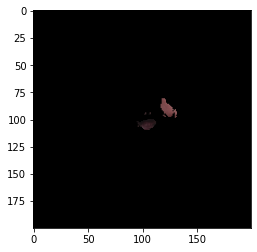

TIDAK_SEGAR
/content/IMG_20210520_132219.jpg


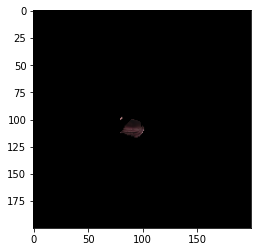

TIDAK_SEGAR
/content/IMG_20210520_132941.jpg


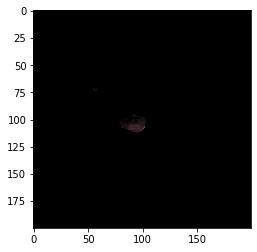

TIDAK_SEGAR
/content/IMG_20210520_132215.jpg


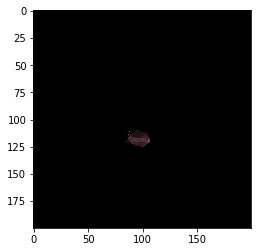

TIDAK_SEGAR
/content/IMG_20210520_132925.jpg


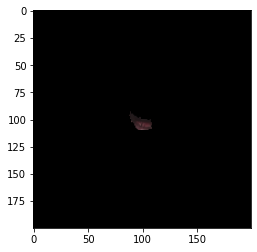

SEGAR
/content/IMG_20210520_132151.jpg


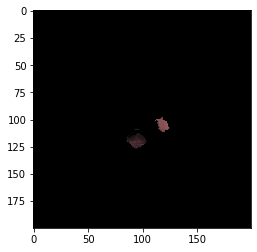

TIDAK_SEGAR


In [ ]:
from glob import glob

for image_name in glob('/content/*.*'):
  predict_gill_freshness_test(image_name, 'bandeng')

# Flask API Biasa

In [ ]:
!pip install flask-ngrok

In [ ]:
from flask import Flask, jsonify, request
from flask_ngrok import run_with_ngrok

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://65da0f023199.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [29/Jun/2021 19:15:30] "GET /jenis/https://firebasestorage.googleapis.com/v0/b/skripsisaya-ikan.appspot.com/o/image_picker3258516666451837839.jpg HTTP/1.1" 200 -


[[1. 0. 0. 0.]]
BANDENG
BANDENG 100%
Fish Class bandeng 100%
Fish Class From Eye bandeng 100%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


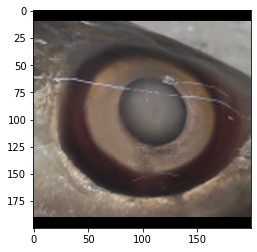

127.0.0.1 - - [29/Jun/2021 19:16:03] "GET /mata/https://firebasestorage.googleapis.com/v0/b/skripsisaya-ikan.appspot.com/o/image_picker2687351741742290337.jpg HTTP/1.1" 200 -


model bandeng
TIDAK_SEGAR


127.0.0.1 - - [29/Jun/2021 19:16:30] "GET /insang/https://firebasestorage.googleapis.com/v0/b/skripsisaya-ikan.appspot.com/o/image_picker4157995788214516540.jpg HTTP/1.1" 200 -


SEGAR
SEGAR 100%


In [ ]:
app = Flask(__name__)
run_with_ngrok(app)   
  
fish_class = ' '

@app.route('/', methods=['GET', 'POST'])
def index():
  if (request.method == 'POST'):
    some_json = request.get_json()
    return jsonify({'you sent': some_json}), 201
  else:
    return jsonify({'about': 'Hello World!'})

@app.route('/jenis/<path:linktoimage>')
def fish_classification(linktoimage):
  image_url = str(linktoimage)
  predict_img = predict_fish_classification(image_url)
  # img = url_to_image(image_url)
  print(predict_img)
  global fish_class
  fish_class = predict_img.lower()
  print('Fish Class ', end='')
  print(fish_class)
  return jsonify({'url': str(image_url), 'jenis': str(predict_img).title()})

@app.route('/setjenis/<jenissetvalue>')
def set_jenis_ikan(jenissetvalue):
  global fish_class
  fish_class = jenissetvalue.lower()
  print('Fish Class after set ', end='')
  print(fish_class)
  return jsonify({'status': 'success', 'jenis': fish_class.title()})

@app.route('/mata/<path:linktoeyeimage>')
def eye_freshness(linktoeyeimage):
  # image_eye = str(linktoeyeimage)
  print('Fish Class From Eye ', end='')
  print(fish_class)
  eye_position = detect_fish_eye_position(linktoeyeimage)
  eye_freshness_prediction = 'Mata Tidak Terdeteksi'
  if (eye_position != 'No Eye Detected'):
    eye_freshness_prediction = predict_eye_freshness(eye_position, fish_class.split(' ')[0])
    # eye_freshness_prediction = eye_freshness_prediction.replace('_', ' ')
  return jsonify({'url': str(linktoeyeimage), 'jenis': str(fish_class).title(), 'kesegaran_mata': str(eye_freshness_prediction).title()})

@app.route('/insang/<path:linktogillimage>')
def gill_freshness(linktogillimage):
  # image_gill = str(linktogillimage)
  gill_freshness_prediction = predict_gill_freshness(linktogillimage, fish_class.split(' ')[0])
  # gill_freshness_prediction = gill_freshness_prediction.replace('_', ' ')
  print(gill_freshness_prediction)
  return jsonify({'url': str(linktogillimage), 'jenis': str(fish_class).title(), 'kesegaran_insang': str(gill_freshness_prediction).title()})

if __name__ == '__main__':
  app.run()

In [ ]:
im = url_to_image("https://firebasestorage.googleapis.com/v0/b/skripsisaya-ikan.appspot.com/o/337d2113-4fab-4e20-965c-32b30e84f0e85464851851665598713.jpg?alt=media")
# plt.imshow(im)
im.shape

(1280, 960, 3)

# Flask RESTful

In [ ]:
!pip install Flask-RESTful

     |████████████████████████████████| 61kB 4.2MB/s 


In [ ]:
from flask_restful import Resource, Api

app = Flask(__name__)
api = Api(app)

run_with_ngrok(app)   
  
class HelloWorld(Resource):
  def get(self):
    return {'about':'hello'}

  def post(self):
    some_json = request.get_json()
    return {'sent': some_json}, 201

class Multi(Resource):
  def get(self, num):
    return {'res': num*10}

api.add_resource(HelloWorld, '/')
api.add_resource(Multi, '/multi/<int:num>')

if __name__ == '__main__':
  app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://ab8b3b0dc923.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [07/Apr/2021 09:33:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Apr/2021 09:34:05] "GET /multi/22 HTTP/1.1" 200 -
127.0.0.1 - - [07/Apr/2021 09:34:52] "POST / HTTP/1.1" 400 -
127.0.0.1 - - [07/Apr/2021 09:35:42] "POST / HTTP/1.1" 400 -
